### Load Packages

In [1]:
import torch
import time
import nbimporter
from DataLoader import load_dataset
from ConvNet import get_model
import numpy as np
import cv2
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

Importing Jupyter notebook from DataLoader.ipynb
Importing Jupyter notebook from ConvNet.ipynb


### Keep checking learning rate

In [2]:
def check_lr(optimizer, epoch):
    if epoch >= 10:
        for param_group in opt.param_groups:
            param_group['lr'] *= 0.1

### Copy pretrained model

In [3]:
def copy_pretrain_vals(model, vgg_dict, isstrict):
    model.load_state_dict(vgg_dict,strict=isstrict)
    return model

### Generating a file list array for data loader

In [4]:
def get_files_list(fg_file, bg_file):
    fg_list = []
    bg_list = []
    with open(fg_file, 'r') as f:
        fg_list = f.readlines()
    with open(bg_file, 'r') as f:
        bg_list = f.readlines()
    for i in range(len(fg_list)):
        fg_list[i] = fg_list[i].strip('\n').strip('\r')
    for i in range(len(bg_list)):
        bg_list[i] = bg_list[i].strip('\n').strip('\r')
    arr = []
    cnt = 0
    for i in range(len(fg_list)):
        for j in range(20):
            arr.append((fg_list[i], bg_list[cnt], fg_list[i], fg_list[i].strip('.png') + '_' + str(j) + '.png'))
            cnt += 1
    return arr

### Test model function

In [5]:
def test_model(model, dataset, trimap_path, cuda=False):
    model.eval()
    mse_diffs = 0.
    sad_diffs = 0.
    for iteration in range(dataset.__len__()):
        torch.cuda.empty_cache()
        file_info =  dataset.__getinfo__(iteration)
        print(file_info)
        batch = dataset.__getitem__(iteration)
        if batch == None:
            continue
#         print('oompa')
#         print(batch[0].shape)
        batch0 = batch[0].reshape(1, batch[0].shape[0], batch[0].shape[1], batch[0].shape[2])
        batch1 = batch[1].reshape(1, batch[1].shape[0], batch[1].shape[1], batch[1].shape[2])
        batch2 = batch[2].reshape(1, batch[2].shape[0], batch[2].shape[1], batch[2].shape[2])
        batch3 = batch[3].reshape(1, batch[3].shape[0], batch[3].shape[1], batch[3].shape[2])
        batch4 = batch[4].reshape(1, batch[4].shape[0], batch[4].shape[1], batch[4].shape[2])
        img = Variable(batch0)
        alpha = Variable(batch1)
        fg = Variable(batch2)
        bg = Variable(batch3)
#         trimap = Variable(batch4)
        trimap = cv2.imread(trimap_path + file_info[3])[:, :, 0]
#         cv2.imwrite('trimap.jpg', trimap)
#         print('########')
#         print(img.shape)
        trimap = cv2.resize(trimap, (img.shape[3], img.shape[2]), interpolation=cv2.INTER_LINEAR)
#         print(trimap.shape)
        trimap = torch.from_numpy(trimap.astype(np.float32)[np.newaxis, :, :])
#         print(trimap.size())
        trimap = trimap.reshape(1, trimap.shape[0], trimap.shape[1], trimap.shape[2])
#         print(trimap.size())
        trimap = Variable(trimap)
        if cuda:
            img = img.cuda()
            alpha = alpha.cuda()
            fg = fg.cuda()
            bg = bg.cuda()
            trimap = trimap.cuda()

        pred_alpha = model(torch.cat((img, trimap), 1))
        pred_alpha = pred_alpha.data
        if cuda:
            pred_alpha = pred_alpha.cpu()
        pred_alpha = pred_alpha.numpy()[0, 0, :, :]
        pred_alpha[trimap == 255] = 1.
        pred_alpha[trimap == 0 ] = 0.
        pixel = float((trimap == 128).sum())
        alpha = cv2.imread('/scratch/matting/dataset/Test_set/adobe/alpha/' + file_info[2])[:, :, 0]
        alpha = cv2.resize(alpha, (pred_alpha.shape[1], pred_alpha.shape[0]), interpolation=cv2.INTER_LINEAR)
        cv2.imwrite('alpha.jpg', alpha)
        alpha = alpha / 255.
        print('############')
        print(pred_alpha.shape, alpha.shape)
        mse_diff = ((pred_alpha - alpha) ** 2).sum() / pixel
        sad_diff = np.abs(pred_alpha - alpha).sum()
        mse_diffs += mse_diff
        sad_diffs += sad_diff
        print(mse_diffs/(iteration+1), sad_diffs/(iteration+1), iteration)
        pred_alpha = (pred_alpha * 255).astype(np.uint8)
        print(pred_alpha)
        cv2.imwrite('alpha_pred.png', pred_alpha)
        plt.imshow(pred_alpha)
        if iteration == 40:
            break

### Save model

In [6]:
def save_model(path, model):
    torch.save(model, path)

### Main function

/home/subramanyam.m/Deep-Image-Matting/venv/local/lib/python2.7/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type EDNet. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


EDNet(
  (conv1_1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 51

############
((320, 320), (320, 320))
(0.1592606145293187, 13397.592342123635, 18)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [11  1  0 ... 18 29 64]
 ...
 [14  2  0 ...  2  9 35]
 [27  8  3 ... 14 33 70]
 [59 32 20 ... 51 83 97]]
('16452523375_08591714cf_o.png', '2007_000323.jpg', '16452523375_08591714cf_o.png', '16452523375_08591714cf_o_19.png')
############
((320, 320), (320, 320))
(0.16062937847384787, 13453.801262243996, 19)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [18  4  1 ... 15 24 50]
 ...
 [ 9  1  0 ...  0  1 14]
 [21  6  1 ...  1  7 34]
 [50 24 15 ... 13 26 61]]
('antique-honiton-lace-1182740_1920.png', '2007_000332.jpg', 'antique-honiton-lace-1182740_1920.png', 'antique-honiton-lace-1182740_1920_0.png')
############
((320, 320), (320, 320))
(0.17677169800376677, 15825.400623026975, 20)
[[ 0  0  0 ...  0  0  0]
 [17  3  1 ...  3 10 29]
 [ 9  1  0 ...  1  4 24]
 ...
 [ 2  0  0 ...  0  0  7]
 [ 6  1  0 ...  0  1 13]
 [19  6  2 ...  2  8 28]]
('antique-honiton

############
((320, 320), (320, 320))
(0.31196348797413964, 36183.82440371275, 40)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 8  1  0 ...  2  6 26]
 ...
 [13  3  1 ...  0  0  5]
 [28 10  3 ...  0  2 17]
 [52 27 14 ...  6 12 33]]


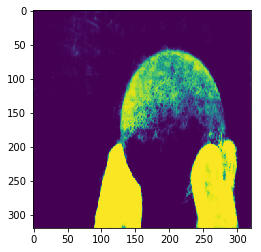

In [7]:
def main(cuda=False):
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found")
    if cuda:
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)
    
    fg_path = '/scratch/matting/dataset/Test_set/adobe/fg/'
    bg_path = '/scratch/matting/dataset/VOCO_dataset/'
    alpha_path = '/scratch/matting/dataset/Test_set/adobe/alpha/'
    trimap_path = '/scratch/matting/dataset/Test_set/adobe/trimaps/'
#     vgg_path = '/scratch/matting/dataset/full_trained.pth'
    vgg_path = '/scratch/matting/model_1.pth'
    fg_file = '/scratch/matting/dataset/Test_set/test_fg_names.txt'
    bg_file = '/scratch/matting/dataset/Test_set/test_bg_names.txt'
    files_list = get_files_list(fg_file, bg_file)
#     print(files_list)
    dataset = load_dataset(fg_path, alpha_path, bg_path, files_list)
    model = get_model()
    vgg_dict = torch.load(vgg_path, map_location='cpu')
#     vgg_dict = torch.load_state_dict(vgg_dict)
#     model = copy_pretrain_vals(model, vgg_dict["state_dict"], True)
    model = copy_pretrain_vals(model, vgg_dict.state_dict(), True)
    print(model)
    if cuda:
        model = model.cuda()
    test_model(model, dataset, trimap_path, cuda)
main()